In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nuztf.neutrino_scanner import NeutrinoScanner
from astropy import units as u
from nuwinter.avro import load_avro
from nuwinter.plot import ann_fields, generate_single_page
from nuwinter.utils import deduplicate_df
from nuwinter.paths import get_pdf_path
from pathlib import Path
import pandas as pd
import json
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from tqdm import tqdm
from nuztf.skymap_scanner import SkymapScanner
from winterapi import WinterAPI
from astropy.time import Time
from mocpy import MOC
from astropy.coordinates import (
    ICRS,
    Angle,
    BaseCoordinateFrame,
    Galactic,
    Latitude,
    Longitude,
    SkyCoord,
)
from astropy.io import fits
import healpy as hp
import logging

/opt/anaconda3/envs/nuwinter/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
# Program details
program = "2023A001" # WINTER EMGW

name = "S250206dm"

prob_threshold = 0.95
n_days = 14

image_type="diff"

In [4]:
winter = WinterAPI()
program_list = winter.get_programs()
print(f"Available programs: {program_list}")
assert program in program_list, f"program {program} not found! Add this program first."

INFO:winterapi.messenger:API ping success is True
INFO:winterapi.messenger:Server requires minimum winterapi version: 1.5.0
INFO:winterapi.messenger:Local winterapi version: 1.5.0


Available programs: ['2023A001']


In [5]:
nu = NeutrinoScanner(name) if "IC" in name else SkymapScanner(
    event=name,
    prob_threshold=prob_threshold,
    n_days=n_days,
    output_nside=1024
)

INFO:nuztf.skymap:Obtaining skymap from GraceDB
INFO:nuztf.skymap:Found voevent S250206dm-7-Update.xml
INFO:nuztf.skymap:Latest skymap URL: https://gracedb.ligo.org/api/superevents/S250206dm/files/Bilby.offline1.multiorder.fits,0
INFO:nuztf.skymap:Saving to: /Users/rdstein/Data/nuztf/skymaps/S250206dm_rev7_Bilby.offline1.multiorder.fits,0
INFO:nuztf.skymap:Reading file: /Users/rdstein/Data/nuztf/skymaps/S250206dm_rev7_Bilby.offline1.multiorder.fits,0
INFO:nuztf.skymap:Rasterising skymap to convert to nested format
INFO:nuztf.skymap:Summed probability is 100.0%
INFO:nuztf.skymap:Regridding to nside 1024
INFO:nuztf.skymap:Event time: 2025-02-06T21:25:30.452
INFO:nuztf.skymap:Reading map
INFO:nuztf.skymap:Threshold found! 
 To reach 95.00% of probability, pixels with probability greater than 3.9e-07 are included.
INFO:nuztf.skymap_scanner:hottest_pixel: 38.17319848293299 53.23540420437919
INFO:nuztf.skymap_scanner:Checking which pixels are within the contour:
100%|████████████████████████

In [6]:
nu.t_min.isot.split("T")[0].replace("-", "")

'20250206'

In [7]:
t_end = min([nu.default_t_max, Time.now()])

res, stacks = winter.query_images_by_program(
    program, image_type="stack",
    start_date=nu.t_min.isot.split("T")[0].replace("-", ""),
    end_date=t_end.isot.split("T")[0].replace("-", "")
)

Querying images for 2023A001 between 20250206 and 20250220 of type 'stack'


In [8]:
res.json()["msg"]

'Request passed validation! Found 465 images.'

In [9]:
stacks

,progname,nightdate,targname,ra,dec,fid,utctime,fieldid,image_type,savepath,lastmodified,pipeversion
0,2023A001,2025-02-09,2025ban,152.84400,-18.875515,2,2025-02-09T16:58:45.274000+00:00,999999999,stack,/data/loki/data/winter/20250208/final/WINTERca...,2025-02-09T11:13:09.883864+00:00,0.19.0
1,2023A001,2025-02-18,GRB250217C,130.78719,33.327890,2,2025-02-18T12:54:04.434000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
2,2023A001,2025-02-18,GRB250217C,130.80641,32.990776,2,2025-02-18T12:54:04.434000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
3,2023A001,2025-02-18,GRB250217C,131.51578,33.681920,2,2025-02-18T12:56:11.930000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
4,2023A001,2025-02-18,GRB250217C,131.51663,32.995903,2,2025-02-18T12:58:19.039000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
460,2023A001,2025-02-08,S250206dm_neutrino1_1,148.86841,-17.841703,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0
461,2023A001,2025-02-08,S250206dm_neutrino1_1,148.87534,-18.179558,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0
462,2023A001,2025-02-08,S250206dm_neutrino1_1,149.50185,-18.179625,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0
463,2023A001,2025-02-08,S250206dm_neutrino1_1,149.50322,-17.494430,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0


In [10]:
print(stacks["utctime"][0], stacks["savepath"][0])

2025-02-09T16:58:45.274000+00:00 /data/loki/data/winter/20250208/final/WINTERcamera_20250209-085845-274_mef_4_0_0_stack.fits


/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_82446/3161930814.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(stacks["utctime"][0], stacks["savepath"][0])


In [11]:
res, diffs = winter.query_images_by_program(
    program, image_type="diff",
    start_date=nu.t_min.isot.split("T")[0].replace("-", ""),
    end_date=t_end.isot.split("T")[0].replace("-", "")
)

Querying images for 2023A001 between 20250206 and 20250220 of type 'diff'


In [12]:
diffs

,progname,nightdate,targname,ra,dec,fid,utctime,fieldid,image_type,savepath,lastmodified,pipeversion
0,2023A001,2025-02-18,GRB250217C,130.787190,33.327890,2,2025-02-18T12:54:04.434000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
1,2023A001,2025-02-18,GRB250217C,130.806410,32.990776,2,2025-02-18T12:54:04.434000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
2,2023A001,2025-02-18,GRB250217C,131.515780,33.681920,2,2025-02-18T12:56:11.930000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
3,2023A001,2025-02-18,GRB250217C,131.516630,32.995903,2,2025-02-18T12:58:19.039000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
4,2023A001,2025-02-08,S250206dm,36.099724,55.324870,2,2025-02-08T15:54:14.173000+00:00,3635,diff,/data/loki/data/winter/20250207/diffs/WINTERca...,2025-02-08T11:08:34.697189+00:00,0.19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
369,2023A001,2025-02-17,S250206dm,32.940460,51.025360,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.372927+00:00,0.19.0
370,2023A001,2025-02-17,S250206dm,32.952366,50.688004,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.282405+00:00,0.19.0
371,2023A001,2025-02-17,S250206dm,33.894040,50.690525,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.372927+00:00,0.19.0
372,2023A001,2025-02-17,S250206dm,33.899640,51.375286,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.372927+00:00,0.19.0


In [13]:
stack_roots = [Path(x).name.split(".")[0] for x in stacks["savepath"]]
diff_roots = [Path(x).name.split(".")[0] for x in diffs["savepath"]]
has_diff = [x in diff_roots for x in stack_roots]

In [153]:
stack_roots

['WINTERcamera_20250209-085845-274_mef_4_0_0_stack',
 'WINTERcamera_20250218-045404-434_mef_6_0_0_stack',
 'WINTERcamera_20250218-045404-434_mef_2_0_0_stack',
 'WINTERcamera_20250218-045611-930_mef_1_0_0_stack',
 'WINTERcamera_20250218-045819-039_mef_4_0_0_stack',
 'WINTERcamera_20250208-075414-173_mef_5_0_0_stack',
 'WINTERcamera_20250208-075414-173_mef_6_0_0_stack',
 'WINTERcamera_20250208-075414-173_mef_2_0_0_stack',
 'WINTERcamera_20250208-075414-173_mef_4_0_0_stack',
 'WINTERcamera_20250208-075414-173_mef_1_0_0_stack',
 'WINTERcamera_20250208-075621-321_mef_3_0_0_stack',
 'WINTERcamera_20250208-064450-635_mef_5_0_0_stack',
 'WINTERcamera_20250208-064450-635_mef_6_0_0_stack',
 'WINTERcamera_20250208-064450-635_mef_2_0_0_stack',
 'WINTERcamera_20250208-064450-635_mef_4_0_0_stack',
 'WINTERcamera_20250208-064450-635_mef_1_0_0_stack',
 'WINTERcamera_20250208-064450-635_mef_3_0_0_stack',
 'WINTERcamera_20250208-060731-997_mef_5_0_0_stack',
 'WINTERcamera_20250208-060731-997_mef_6_0_0_s

In [14]:
# mocs = MOC.from_boxes(
#     lon=images["ra"].to_numpy() * u.deg,
#     lat=images["dec"].to_numpy()  * u.deg,
#     a=0.5 * u.deg,
#     b=0.4 * u.deg,
#     angle=0 * u.deg,
#     max_depth=hp.nside2order(nu.nside),  # Match winter nside/order to skymap nside/order
# )

mocs = MOC.from_boxes(
    lon=stacks["ra"].to_numpy() * u.deg,
    lat=stacks["dec"].to_numpy()  * u.deg,
    a=0.25 * u.deg,
    b=0.2 * u.deg,
    angle=0 * u.deg,
    max_depth=hp.nside2order(nu.nside),  # Match winter nside/order to skymap nside/order
)

In [15]:
image_paths = dict()

In [16]:
# images["ra"]

In [17]:
print(nu.nside)

1024


In [18]:
pixels = [x.flatten() for x in mocs]
all_times = [Time(x.split("+")[0], format="isot") - 8*u.hour for x in stacks["utctime"]]  # 8 hours offset, database times are palomar
# all_times

In [19]:
pix_obs_times = dict()
image_paths = dict()
pix_has_diff = []

for i, obs_time in tqdm(enumerate(all_times), total=len(all_times)):
    
    pixels = hp.nest2ring(nu.nside, np.array(mocs[i].flatten(), dtype=int))

    for p in pixels:
        if p not in pix_obs_times.keys():
            pix_obs_times[p] = [obs_time]
            image_paths[int(p)] = [stacks["savepath"][i]]
        else:
            pix_obs_times[p] += [obs_time]
            image_paths[int(p)] += [stacks["savepath"][i]]

    if has_diff[i]:
        pix_has_diff += list(pixels)

pix_has_diff = list(set(pix_has_diff))

/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_82446/3999189621.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_paths[int(p)] = [stacks["savepath"][i]]
/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_82446/3999189621.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_paths[int(p)] += [stacks["savepath"][i]]
100%|███████████████████████████████████████| 465/465 [00:00<00:00, 3952.43it/s]


In [22]:
ra, dec = 32.429847, 53.572233 	

In [23]:
def get_pixel_number(ra_deg, dec_deg) -> int:
    x = hp.pixelfunc.ang2pix(
        nu.nside, theta=ra_deg, phi=dec_deg, lonlat=True
    )
    return int(x)

def get_matching_images(ra_deg, dec_deg):
    idx = get_pixel_number(ra_deg, dec_deg)
    
    return image_paths[idx] if idx in image_paths else []

In [24]:
get_matching_images(ra, dec)

['/data/loki/data/winter/20250207/final/WINTERcamera_20250208-073658-394_mef_5_0_0_stack.fits',
 '/data/loki/data/winter/20250210/final/WINTERcamera_20250211-033457-218_mef_4_0_0_stack.fits',
 '/data/loki/data/winter/20250216/final/WINTERcamera_20250217-043213-554_mef_5_0_0_stack.fits']

In [53]:
# Download the TNS after JSON for GW event, 
from nuwinter.paths import get_pdf_path


name = "S250206dm"

tns_dir = get_pdf_path(name).parent.parent

print(f"Looking for TNS json in {tns_dir}")

tns_blob = list(tns_dir.glob("*.json"))

tns_df = pd.read_json(tns_blob[0]).transpose() if len(tns_blob) > 0 else pd.DataFrame()
tns_df

Looking for TNS json in /Users/rdstein/Data/nuwinter/S250206dm


,name_prefix,name,ra,declination,type,source_group,discoverymag,filter,discoverydate,credibility_level,within_region
2025bnx,AT,2025bnx,243.1983388877001,-68.82776127375323,None,GW-MMADS,20.5293,r,2025-02-13 07:39:14.688,0.447,50.0%
2025bno,AT,2025bno,242.69847376101356,-68.4704449089745,None,GW-MMADS,21.1144,i,2025-02-13 06:38:00.096,0.488,50.0%
2025bnm,AT,2025bnm,245.7173645297777,-69.0233069359075,None,GW-MMADS,22.1041,i,2025-02-13 06:46:37.632,0.46,50.0%
2025bnl,AT,2025bnl,242.33079763537705,-69.34194454572027,None,GW-MMADS,21.3403,i,2025-02-13 06:38:00.096,0.449,50.0%
2025bnh,AT,2025bnh,248.1591995919586,-68.51748068351628,None,GW-MMADS,21.4456,i,2025-02-13 07:06:47.232,0.497,50.0%
...,...,...,...,...,...,...,...,...,...,...,...
2025bai,AT,2025bai,151.935085324,-20.3429319805,None,Pan-STARRS,19.78,r,2025-02-07 10:16:09.696,0.935,99.0%
2025bah,AT,2025bah,152.779895922,-21.3745584038,Galaxy,Pan-STARRS,18.69,r,2025-02-07 10:08:38.688,0.92,99.0%
2025baf,AT,2025baf,158.506624546,-29.7469922495,None,Pan-STARRS,19.33,r,2025-02-07 09:48:18.720,0.947,99.0%
2025bar,SN,2025bar,170.681922,-45.574606,SN Ia,GOTO,20.23,L,2025-02-07 13:52:45.120,0.945,99.0%


In [158]:
has_coverage = []
all_matches = []
in_95 = []
has_diffs = []

for _, row in tns_df.iterrows():
    matches = get_matching_images(float(row["ra"]), float(row["declination"]))
    has_coverage.append(len(matches) > 0)
    all_matches.append(matches)
    in_95.append(nu.in_contour(float(row["ra"]), float(row["declination"])))
    has_diffs.append([Path(x).name.split(".")[0] in diff_roots for x in matches])

In [159]:
tns_df["has_coverage"] = has_coverage
tns_df["matches"] = all_matches
tns_df["has_diffs"] = has_diffs
tns_df["in_95"] = in_95

In [160]:
tns_df["in_95"].sum()

np.int64(95)

In [161]:
tns_df[tns_df["has_coverage"]]

,name_prefix,name,ra,declination,type,source_group,discoverymag,filter,discoverydate,credibility_level,within_region,has_coverage,matches,in_95,has_diffs
2025bmq,AT,2025bmq,38.517583,54.572472,None,WL-GW,20.0,i,2025-02-08 21:42:00.000,0.16,50.0%,True,[/data/loki/data/winter/20250207/final/WINTERc...,True,"[True, True, True, True, True]"
2025bbp,AT,2025bbp,153.782352138,-22.8815925465,None,Pan-STARRS,20.77,r,2025-02-08 10:20:04.704,0.919,99.0%,True,[/data/loki/data/winter/20250207/final/WINTERc...,True,"[False, False]"
2025ban,AT,2025ban,152.917705546,-18.9522025627,None,Pan-STARRS,20.41,r,2025-02-07 10:25:07.104,0.955,99.0%,True,[/data/loki/data/winter/20250208/final/WINTERc...,False,[False]
2025baj,AT,2025baj,156.516533253,-28.3455340139,None,Pan-STARRS,19.97,r,2025-02-07 10:07:50.304,0.926,99.0%,True,[/data/loki/data/winter/20250207/final/WINTERc...,True,"[False, False, False]"


In [78]:
tns_df[~tns_df["in_95"]]

,name_prefix,name,ra,declination,type,source_group,discoverymag,filter,discoverydate,credibility_level,within_region,has_coverage,matches,in_95
2025bxh,AT,2025bxh,176.067351,-48.819662,None,GOTO,18.12,L,2025-02-15 11:11:23.136,0.989,99.0%,False,[],False
2025bwl,AT,2025bwl,357.788004708,34.1967810531,None,Pan-STARRS,19.89,r,2025-02-13 05:35:59.712,0.976,99.0%,False,[],False
2025bfc,AT,2025bfc,150.373497669,-18.4020737682,None,Pan-STARRS,19.15,r,2025-02-08 10:34:54.624,0.961,99.0%,False,[],False
2025bea,AT,2025bea,163.837726667,-45.4580533333,None,ATLAS,19.63,orange,2025-02-07 04:52:03.648,0.971,99.0%,False,[],False
2025bdx,AT,2025bdx,151.510333,-20.883056,None,MASTER,19.5,Other,2025-02-10 07:52:04.512,0.964,99.0%,False,[],False
2025bdh,AT,2025bdh,149.310625,-15.5635,None,MASTER,19.2,Other,2025-02-07 06:50:41.280,0.958,99.0%,False,[],False
2025bci,AT,2025bci,151.739711737,-22.1493082623,None,Pan-STARRS,20.38,r,2025-02-08 10:26:34.368,0.965,99.0%,False,[],False
2025bch,AT,2025bch,150.851249036,-24.9280852363,None,Pan-STARRS,19.18,r,2025-02-08 10:24:42.048,0.981,99.0%,False,[],False
2025bcg,AT,2025bcg,151.31364174,-22.827380782,None,Pan-STARRS,20.11,r,2025-02-08 10:20:04.704,0.973,99.0%,False,[],False
2025bcf,AT,2025bcf,154.04184099,-19.557034559,None,Pan-STARRS,20.34,r,2025-02-08 10:33:59.328,0.965,99.0%,False,[],False


(array([58.,  1.,  3., 17.,  9.,  0.,  0.,  5.,  7., 16.]),
 array([-72.14287378, -59.39433832, -46.64580286, -33.8972674 ,
        -21.14873194,  -8.40019647,   4.34833899,  17.09687445,
         29.84540991,  42.59394537,  55.34248084]),
 <BarContainer object of 10 artists>)

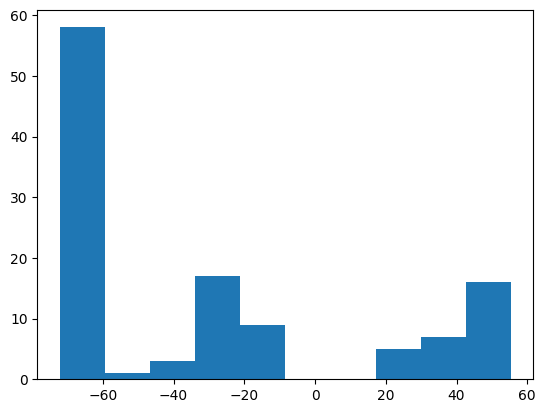

In [79]:
plt.hist(tns_df["declination"].astype(float))

(array([18.,  4.,  0.,  0., 30.,  1., 46., 11.,  0.,  6.]),
 array([  1.9074387 ,  37.64341781,  73.37939692, 109.11537603,
        144.85135514, 180.58733425, 216.32331336, 252.05929247,
        287.79527158, 323.53125069, 359.2672298 ]),
 <BarContainer object of 10 artists>)

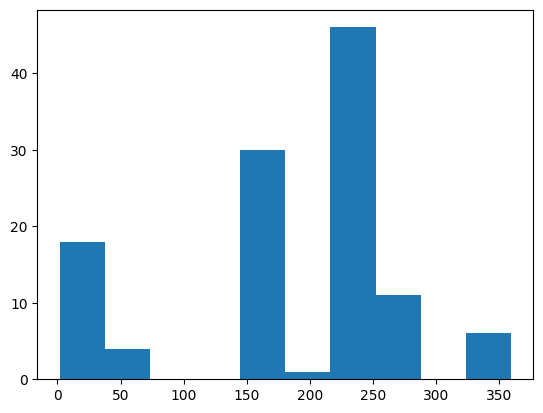

In [80]:
plt.hist(tns_df["ra"].astype(float))

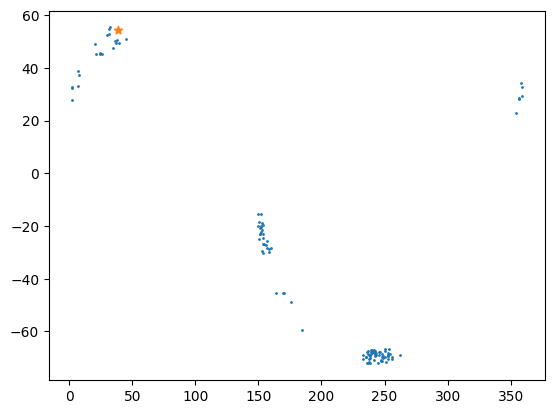

In [163]:
plt.scatter(tns_df["ra"].astype(float), tns_df["declination"].astype(float), s=1.)
plt.scatter(38.517583, 54.572472, marker="*")

In [84]:
mask = tns_df["has_coverage"]
tns_df[mask]

,name_prefix,name,ra,declination,type,source_group,discoverymag,filter,discoverydate,credibility_level,within_region,has_coverage,matches,in_95
2025bmq,AT,2025bmq,38.517583,54.572472,None,WL-GW,20.0,i,2025-02-08 21:42:00.000,0.16,50.0%,True,[/data/loki/data/winter/20250207/final/WINTERc...,True
2025bbp,AT,2025bbp,153.782352138,-22.8815925465,None,Pan-STARRS,20.77,r,2025-02-08 10:20:04.704,0.919,99.0%,True,[/data/loki/data/winter/20250207/final/WINTERc...,True
2025ban,AT,2025ban,152.917705546,-18.9522025627,None,Pan-STARRS,20.41,r,2025-02-07 10:25:07.104,0.955,99.0%,True,[/data/loki/data/winter/20250208/final/WINTERc...,False
2025baj,AT,2025baj,156.516533253,-28.3455340139,None,Pan-STARRS,19.97,r,2025-02-07 10:07:50.304,0.926,99.0%,True,[/data/loki/data/winter/20250207/final/WINTERc...,True


In [86]:
images = [x for y in tns_df[mask]["matches"] for x in y]
images

['/data/loki/data/winter/20250207/final/WINTERcamera_20250208-064450-635_mef_4_0_0_stack.fits',
 '/data/loki/data/winter/20250207/final/WINTERcamera_20250208-044049-702_mef_5_0_0_stack.fits',
 '/data/loki/data/winter/20250209/final/WINTERcamera_20250210-051534-858_mef_4_0_0_stack.fits',
 '/data/loki/data/winter/20250210/final/WINTERcamera_20250211-073914-646_mef_5_0_0_stack.fits',
 '/data/loki/data/winter/20250215/final/WINTERcamera_20250216-064235-133_mef_5_0_0_stack.fits',
 '/data/loki/data/winter/20250207/final/WINTERcamera_20250208-110414-707_mef_3_0_0_stack.fits',
 '/data/loki/data/winter/20250210/final/WINTERcamera_20250211-092920-609_mef_3_0_0_stack.fits',
 '/data/loki/data/winter/20250208/final/WINTERcamera_20250209-085845-274_mef_4_0_0_stack.fits',
 '/data/loki/data/winter/20250207/final/WINTERcamera_20250208-112147-004_mef_2_0_0_stack.fits',
 '/data/loki/data/winter/20250207/final/WINTERcamera_20250208-094637-638_mef_1_0_0_stack.fits',
 '/data/loki/data/winter/20250210/final/

In [87]:
# res, output_path = winter.download_image_list(program_name=program, image_type="stack", paths=images)
# print(f"Saved images to {output_path}")
# print(res.headers)
# res.raise_for_status()

INFO:winterapi.base_api:Downloaded file to /Users/rdstein/WINTER_images_stack_2025_04_02_16_27_39.zip


Saved images to /Users/rdstein/WINTER_images_stack_2025_04_02_16_27_39.zip
{'Server': 'nginx/1.14.1', 'Date': 'Wed, 02 Apr 2025 23:27:46 GMT', 'Content-Type': 'application/x-zip-compressed', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'content-disposition': 'attachment; filename=WINTER_images_stack_2025_04_02_16_27_39.zip', 'missing-images': '0', 'total-images': '11', 'image-type': 'stack'}


In [132]:
stack_dir = get_pdf_path(name).parent.parent / "stack"

print(f"Looking for images in {stack_dir}")

Looking for images in /Users/rdstein/Data/nuwinter/S250206dm/stack


In [133]:
for _, row in tns_df[mask].iterrows():
    
    print(row)
    print(row["matches"])

name_prefix                                                         AT
name                                                           2025bmq
ra                                                           38.517583
declination                                                  54.572472
type                                                              None
source_group                                                     WL-GW
discoverymag                                                      20.0
filter                                                               i
discoverydate                                  2025-02-08 21:42:00.000
credibility_level                                                 0.16
within_region                                                    50.0%
has_coverage                                                      True
matches              [/data/loki/data/winter/20250207/final/WINTERc...
in_95                                                             True
Name: 

In [134]:
row = tns_df[mask].iloc[0]
print(row)
print(row["matches"])

crds = SkyCoord(float(row["ra"]) * u.deg, float(row["declination"]) * u.deg).to_pixel(wcs)

name_prefix                                                         AT
name                                                           2025bmq
ra                                                           38.517583
declination                                                  54.572472
type                                                              None
source_group                                                     WL-GW
discoverymag                                                      20.0
filter                                                               i
discoverydate                                  2025-02-08 21:42:00.000
credibility_level                                                 0.16
within_region                                                    50.0%
has_coverage                                                      True
matches              [/data/loki/data/winter/20250207/final/WINTERc...
in_95                                                             True
Name: 

In [150]:
all_entries = []

for _, row in tns_df[mask].iterrows():

    for full_path in row["matches"]:
        base_path = Path(full_path).name
        path = stack_dir / base_path
        with fits.open(path) as hdul:
            data = hdul[0].data
            header = hdul[0].header
        
        wcs = WCS(header)

        crds = SkyCoord(float(row["ra"]) * u.deg, float(row["declination"]) * u.deg).to_pixel(wcs)
        
        xs = crds[0]
        ys = crds[1]
        
        apertures = CircularAperture(np.column_stack((xs, ys)), r=5.0)
        bkg = Background2D(data, box_size=(50, 50), filter_size=(3, 3))
        bkg_mean = bkg.background_median
        phot_table = aperture_photometry(data - bkg_mean, apertures, mask=np.isnan(data))
        phot_table["mag"] = -2.5*np.log10(phot_table['aperture_sum'].value) + header["ZP"]
        entry = {
            "name": row["name"],
            "ra": float(row["ra"]),
            "dec": float(row["declination"]),
            "date": header["DATE-OBS"],
            "mlim": header["MAGLIM"],
            "mag": float(phot_table["mag"][0]),
            "flux": phot_table['aperture_sum'].value[0],
            "median": bkg_mean
        }
        all_entries.append(entry)

/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_82446/1039748564.py:23: RuntimeWarning: invalid value encountered in log10
  phot_table["mag"] = -2.5*np.log10(phot_table['aperture_sum'].value) + header["ZP"]
/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_82446/1039748564.py:23: RuntimeWarning: invalid value encountered in log10
  phot_table["mag"] = -2.5*np.log10(phot_table['aperture_sum'].value) + header["ZP"]


In [152]:
res_df = pd.DataFrame(all_entries)
mask = pd.notnull(res_df["flux"])
res_df[mask]

,name,ra,dec,date,mlim,mag,flux,median
0,2025bmq,38.517583,54.572472,2025-02-08T06:44:50.635,18.270517,14.433599,10770.928369,-1.660931
2,2025bmq,38.517583,54.572472,2025-02-10T05:15:34.858,17.718929,14.547756,7460.921840,-0.865901
5,2025bbp,153.782352,-22.881593,2025-02-08T11:04:14.707,17.316711,NaN,-498.479626,-1.014321
6,2025bbp,153.782352,-22.881593,2025-02-11T09:29:20.609,17.022153,16.917653,775.247134,0.246806
7,2025ban,152.917706,-18.952203,2025-02-09T08:58:45.274,14.398231,14.510526,631.137477,-2.480735
8,2025baj,156.516533,-28.345534,2025-02-08T11:21:47.004,14.604682,NaN,-934.408395,2.781597
10,2025baj,156.516533,-28.345534,2025-02-11T10:39:07.412,17.262289,18.824326,256.581709,-0.782404


In [165]:
for _, row in res_df[mask].iterrows():
    print(f'AT{row["name"]} & {row["ra"]:.3f} & {row["dec"]:.3f} & {row["date"]} & {row["mlim"]:.1f} & {row["mag"]:.1f}')

AT2025bmq & 38.518 & 54.572 & 2025-02-08T06:44:50.635 & 18.3 & 14.4
AT2025bmq & 38.518 & 54.572 & 2025-02-10T05:15:34.858 & 17.7 & 14.5
AT2025bbp & 153.782 & -22.882 & 2025-02-08T11:04:14.707 & 17.3 & nan
AT2025bbp & 153.782 & -22.882 & 2025-02-11T09:29:20.609 & 17.0 & 16.9
AT2025ban & 152.918 & -18.952 & 2025-02-09T08:58:45.274 & 14.4 & 14.5
AT2025baj & 156.517 & -28.346 & 2025-02-08T11:21:47.004 & 14.6 & nan
AT2025baj & 156.517 & -28.346 & 2025-02-11T10:39:07.412 & 17.3 & 18.8


In [101]:
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(1075, 1949), dtype='>f4')

In [127]:
header["DATE-OBS"], header["MAGLIM"], header["ZP"]

('2025-02-08T06:44:50.635', 18.270517264108264, 24.514232189468597)

In [128]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import Background2D

In [129]:
phot_table

id,xcenter,ycenter,aperture_sum,mag
int64,float64,float64,float64,float64
1,1660.0525654025892,232.08537046221335,10770.928368750874,14.433599345325435


SyntaxError: '{' was never closed (4283655148.py, line 1)

In [ ]:
all_entries = []